# Generative Adversarial Networks 
- refer to a family of generative models that seek to discover the underlying distribution behind a certain data generating process. This distribution is discovered through an adversarial competition between a generator and a discriminator

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv("A_Z Handwritten Data.csv").astype('float32')
data.head()

0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 785 columns]

In [3]:
width, height, channel = 28, 28, 1

In [4]:
X = data.iloc[:,1:].values
X = X.reshape((372450, width, height))
np.random.shuffle(X)
X.shape

(372450, 28, 28)

In [5]:
X = (X - 127.5) / 127.5

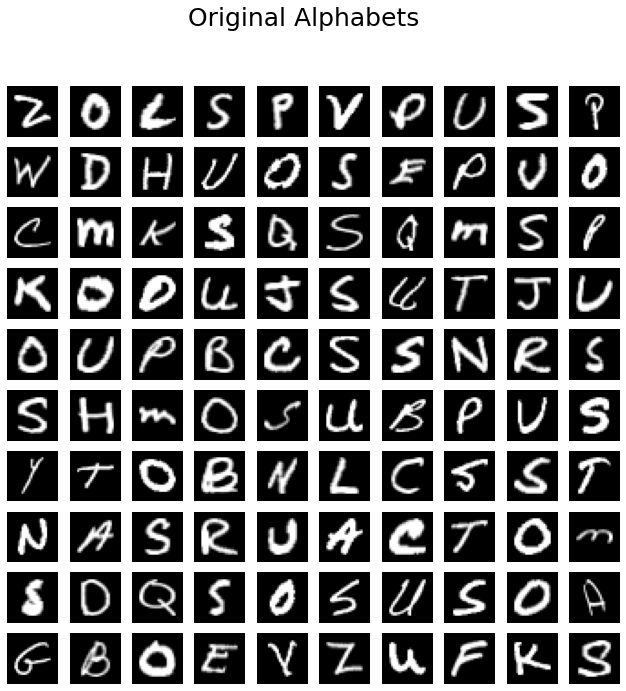

In [6]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [9]:
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_1 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6272)              0

2022-01-12 19:56:19.092806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [11]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)              

In [12]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [13]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         6595073   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


In [14]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [15]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [16]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size

epoch:  0
discriminator loss:  0.5704817771911621
generator loss:  1.35404372215271
--------------------------------------------------------------------------------


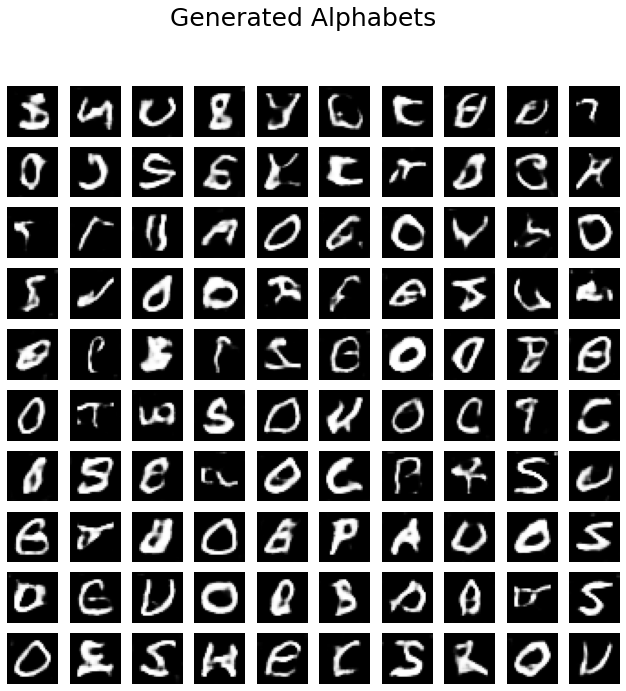

epoch:  1
discriminator loss:  0.5769565105438232
generator loss:  1.283062219619751
--------------------------------------------------------------------------------
epoch:  2
discriminator loss:  0.566230297088623
generator loss:  1.3798315525054932
--------------------------------------------------------------------------------
epoch:  3
discriminator loss:  0.5173568725585938
generator loss:  1.5117771625518799
--------------------------------------------------------------------------------
epoch:  4
discriminator loss:  0.4985179305076599
generator loss:  1.356567621231079
--------------------------------------------------------------------------------
epoch:  5
discriminator loss:  0.538862943649292
generator loss:  1.0742855072021484
--------------------------------------------------------------------------------


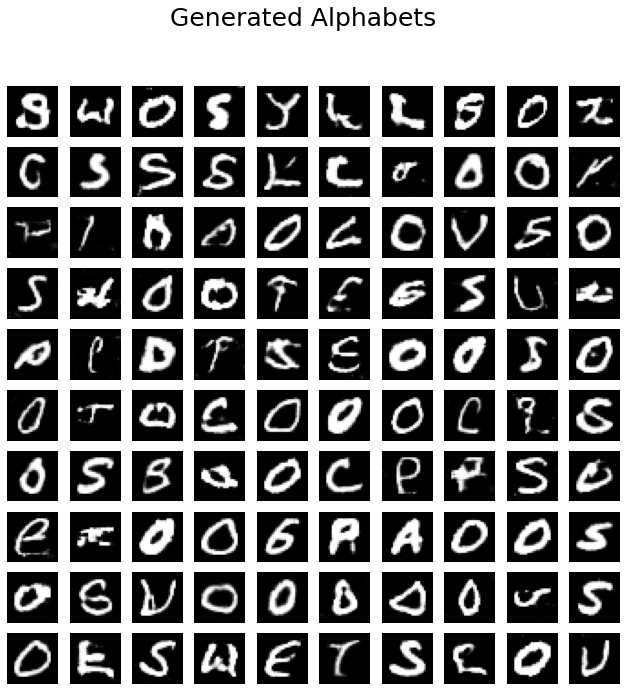

epoch:  6
discriminator loss:  0.47811636328697205
generator loss:  2.056264877319336
--------------------------------------------------------------------------------
epoch:  7
discriminator loss:  0.5042541027069092
generator loss:  1.2016093730926514
--------------------------------------------------------------------------------
epoch:  8
discriminator loss:  0.46545106172561646
generator loss:  1.8450005054473877
--------------------------------------------------------------------------------
epoch:  9
discriminator loss:  0.5034408569335938
generator loss:  2.2453742027282715
--------------------------------------------------------------------------------
epoch:  10
discriminator loss:  0.44922930002212524
generator loss:  1.7524867057800293
--------------------------------------------------------------------------------


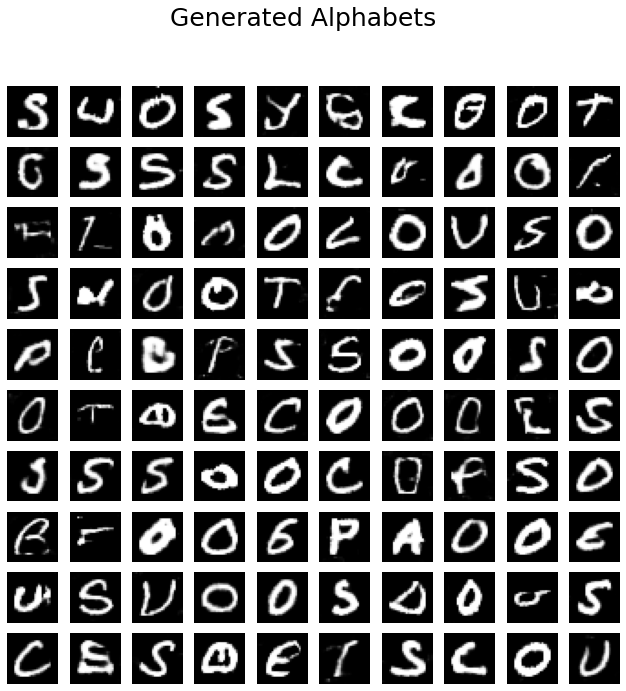

epoch:  11
discriminator loss:  0.46274831891059875
generator loss:  1.3981162309646606
--------------------------------------------------------------------------------
epoch:  12
discriminator loss:  0.4425514340400696
generator loss:  1.766906499862671
--------------------------------------------------------------------------------
epoch:  13
discriminator loss:  0.47254616022109985
generator loss:  1.6483314037322998
--------------------------------------------------------------------------------
epoch:  14
discriminator loss:  0.44908607006073
generator loss:  2.076799154281616
--------------------------------------------------------------------------------
epoch:  15
discriminator loss:  0.4463331699371338
generator loss:  1.5778913497924805
--------------------------------------------------------------------------------


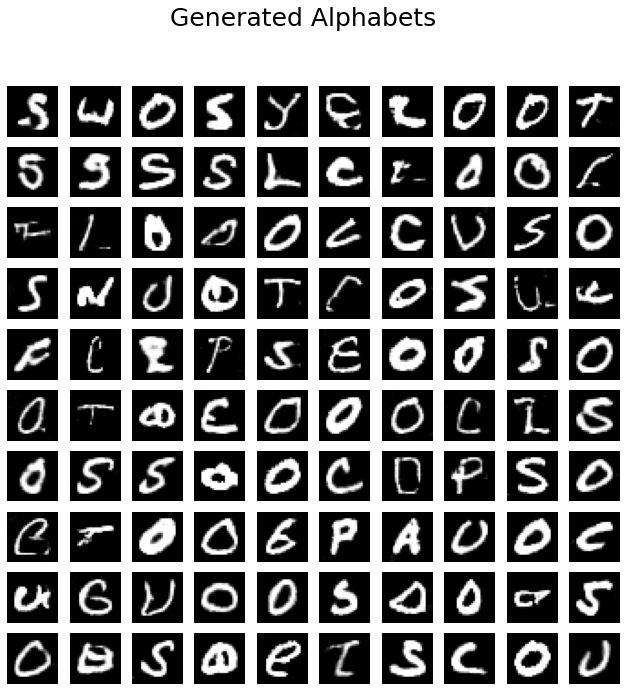

epoch:  16
discriminator loss:  0.45618289709091187
generator loss:  1.6088950634002686
--------------------------------------------------------------------------------
epoch:  17
discriminator loss:  0.45458099246025085
generator loss:  1.8398288488388062
--------------------------------------------------------------------------------
epoch:  18
discriminator loss:  0.4628663659095764
generator loss:  1.526979923248291
--------------------------------------------------------------------------------
epoch:  19
discriminator loss:  0.4584067761898041
generator loss:  1.8457175493240356
--------------------------------------------------------------------------------
epoch:  20
discriminator loss:  0.44155722856521606
generator loss:  1.7777820825576782
--------------------------------------------------------------------------------


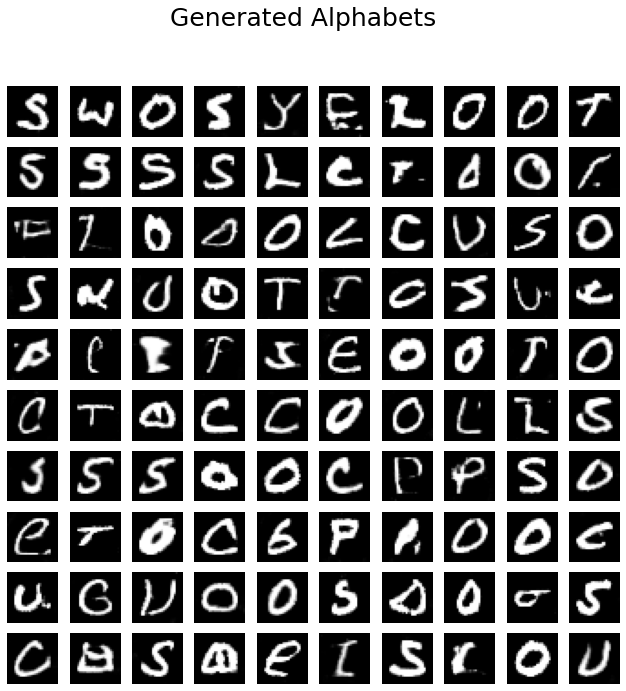

epoch:  21
discriminator loss:  0.4767094850540161
generator loss:  2.424666404724121
--------------------------------------------------------------------------------
epoch:  22
discriminator loss:  0.48665285110473633
generator loss:  1.4556801319122314
--------------------------------------------------------------------------------
epoch:  23
discriminator loss:  0.5367471575737
generator loss:  2.6640284061431885
--------------------------------------------------------------------------------
epoch:  24
discriminator loss:  0.4416600465774536
generator loss:  1.6544592380523682
--------------------------------------------------------------------------------
epoch:  25
discriminator loss:  0.4451834559440613
generator loss:  1.6291043758392334
--------------------------------------------------------------------------------


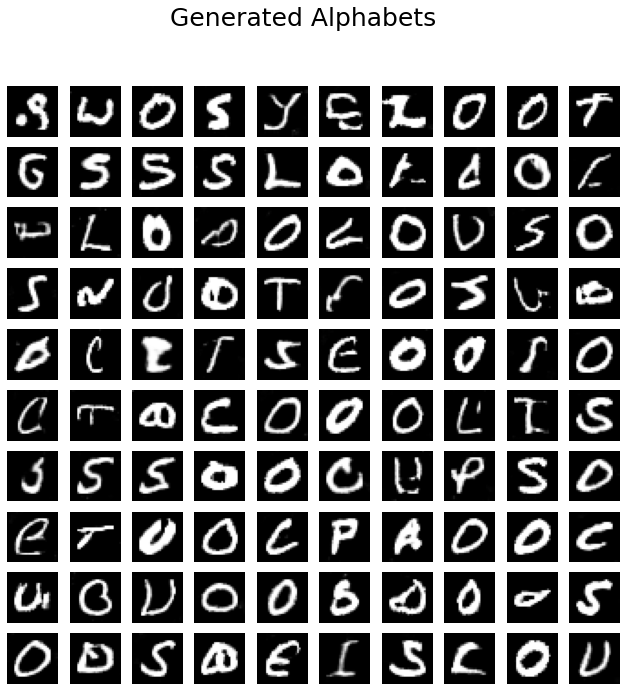

epoch:  26
discriminator loss:  0.43685024976730347
generator loss:  1.332820177078247
--------------------------------------------------------------------------------
epoch:  27
discriminator loss:  0.42292505502700806
generator loss:  1.816058874130249
--------------------------------------------------------------------------------
epoch:  28
discriminator loss:  0.4514370262622833
generator loss:  2.0380048751831055
--------------------------------------------------------------------------------
epoch:  29
discriminator loss:  0.4397258460521698
generator loss:  2.201390266418457
--------------------------------------------------------------------------------
epoch:  30
discriminator loss:  0.475339412689209
generator loss:  2.030259847640991
--------------------------------------------------------------------------------


epoch:  31
discriminator loss:  0.4473469853401184
generator loss:  2.4691286087036133
--------------------------------------------------------------------------------
epoch:  32
discriminator loss:  0.4324016571044922
generator loss:  1.9839208126068115
--------------------------------------------------------------------------------
epoch:  33
discriminator loss:  0.43498939275741577
generator loss:  1.5857717990875244
--------------------------------------------------------------------------------
epoch:  34
discriminator loss:  0.4543134570121765
generator loss:  1.5722157955169678
--------------------------------------------------------------------------------
epoch:  35
discriminator loss:  0.4506596326828003
generator loss:  1.7347887754440308
--------------------------------------------------------------------------------


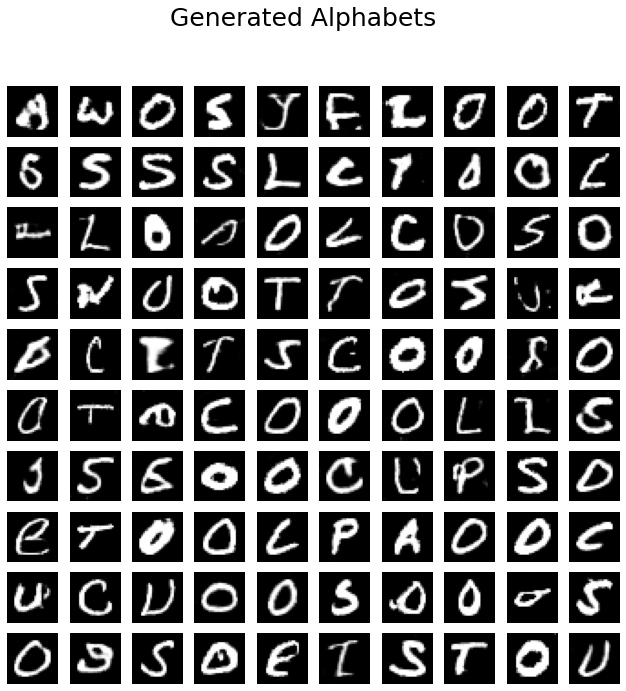

epoch:  36
discriminator loss:  0.4476338028907776
generator loss:  1.9509938955307007
--------------------------------------------------------------------------------
epoch:  37
discriminator loss:  0.4538547694683075
generator loss:  1.5210249423980713
--------------------------------------------------------------------------------
epoch:  38
discriminator loss:  0.4381555914878845
generator loss:  1.4419405460357666
--------------------------------------------------------------------------------
epoch:  39
discriminator loss:  0.440792441368103
generator loss:  1.5852683782577515
--------------------------------------------------------------------------------
epoch:  40
discriminator loss:  0.4490247070789337
generator loss:  1.5162245035171509
--------------------------------------------------------------------------------


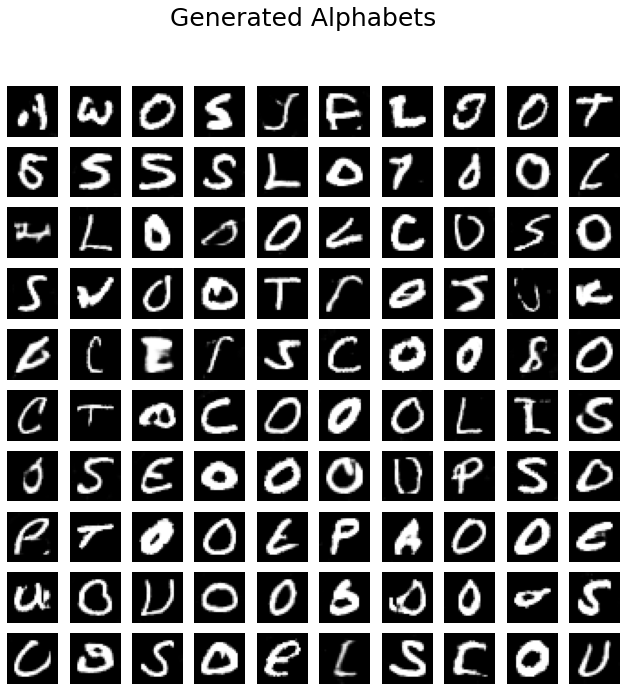

epoch:  41
discriminator loss:  0.4344942569732666
generator loss:  1.795081615447998
--------------------------------------------------------------------------------
epoch:  42
discriminator loss:  0.42635610699653625
generator loss:  1.8424947261810303
--------------------------------------------------------------------------------
epoch:  43
discriminator loss:  0.4393758177757263
generator loss:  1.604906678199768
--------------------------------------------------------------------------------
epoch:  44
discriminator loss:  0.4544905722141266
generator loss:  1.5114872455596924
--------------------------------------------------------------------------------
epoch:  45
discriminator loss:  0.45785537362098694
generator loss:  2.226935386657715
--------------------------------------------------------------------------------


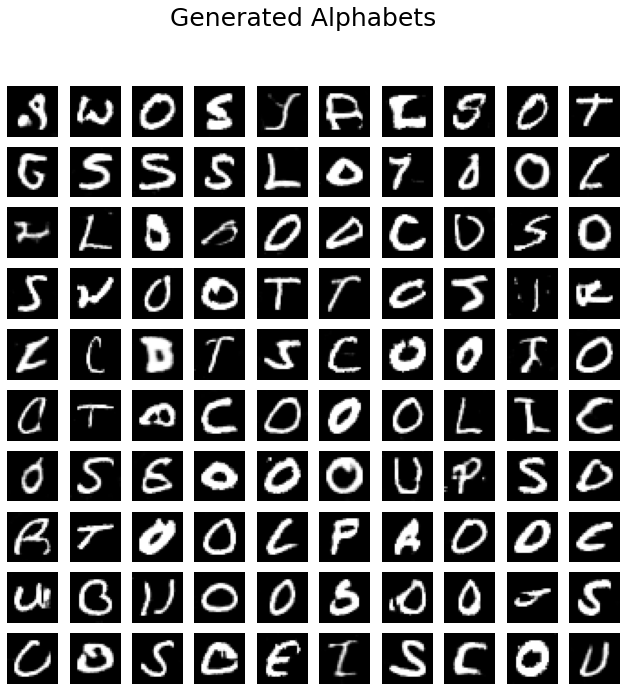

epoch:  46
discriminator loss:  0.44450947642326355
generator loss:  1.7112510204315186
--------------------------------------------------------------------------------
epoch:  47
discriminator loss:  0.4514596462249756
generator loss:  1.4988489151000977
--------------------------------------------------------------------------------
epoch:  48
discriminator loss:  0.4208192825317383
generator loss:  2.0426456928253174
--------------------------------------------------------------------------------
epoch:  49
discriminator loss:  0.4405134916305542
generator loss:  1.3830478191375732
--------------------------------------------------------------------------------
epoch:  50
discriminator loss:  0.4309309124946594
generator loss:  2.13370680809021
--------------------------------------------------------------------------------


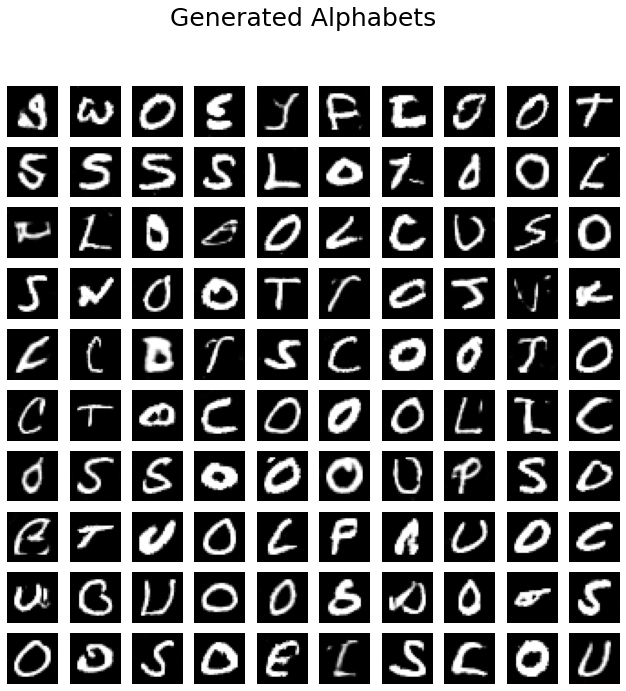

epoch:  51
discriminator loss:  0.4968709647655487
generator loss:  1.4010124206542969
--------------------------------------------------------------------------------
epoch:  52
discriminator loss:  0.435926228761673
generator loss:  2.034663677215576
--------------------------------------------------------------------------------
epoch:  53
discriminator loss:  0.439758837223053
generator loss:  1.7785589694976807
--------------------------------------------------------------------------------
epoch:  54
discriminator loss:  0.45466476678848267
generator loss:  1.329045295715332
--------------------------------------------------------------------------------
epoch:  55
discriminator loss:  0.43684136867523193
generator loss:  2.3614108562469482
--------------------------------------------------------------------------------


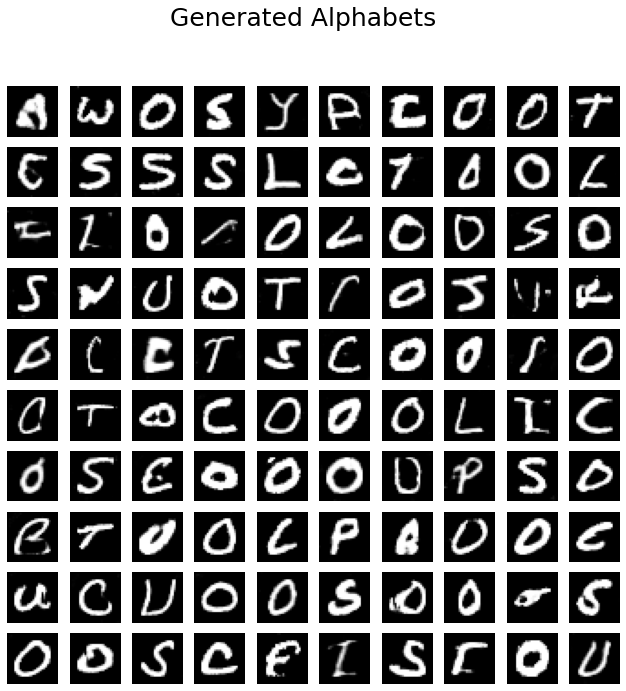

epoch:  56
discriminator loss:  0.4398011565208435
generator loss:  1.6679694652557373
--------------------------------------------------------------------------------
epoch:  57
discriminator loss:  0.43894150853157043
generator loss:  1.5391583442687988
--------------------------------------------------------------------------------
epoch:  58
discriminator loss:  0.4390237033367157
generator loss:  1.7862948179244995
--------------------------------------------------------------------------------
epoch:  59
discriminator loss:  0.45832109451293945
generator loss:  1.780336856842041
--------------------------------------------------------------------------------
epoch:  60
discriminator loss:  0.4405730962753296
generator loss:  1.6619921922683716
--------------------------------------------------------------------------------


epoch:  61
discriminator loss:  0.46001946926116943
generator loss:  2.219243049621582
--------------------------------------------------------------------------------
epoch:  62
discriminator loss:  0.4450800120830536
generator loss:  1.5031473636627197
--------------------------------------------------------------------------------
epoch:  63
discriminator loss:  0.41616517305374146
generator loss:  1.4582183361053467
--------------------------------------------------------------------------------
epoch:  64
discriminator loss:  0.4585719704627991
generator loss:  2.3165383338928223
--------------------------------------------------------------------------------
epoch:  65
discriminator loss:  0.44964709877967834
generator loss:  2.006666898727417
--------------------------------------------------------------------------------


epoch:  66
discriminator loss:  0.45230576395988464
generator loss:  2.0832996368408203
--------------------------------------------------------------------------------
epoch:  67
discriminator loss:  0.42318078875541687
generator loss:  1.7395830154418945
--------------------------------------------------------------------------------
epoch:  68
discriminator loss:  0.42093610763549805
generator loss:  2.0233123302459717
--------------------------------------------------------------------------------
epoch:  69
discriminator loss:  0.4360264539718628
generator loss:  1.753246784210205
--------------------------------------------------------------------------------
epoch:  70
discriminator loss:  0.4445499777793884
generator loss:  1.743896722793579
--------------------------------------------------------------------------------


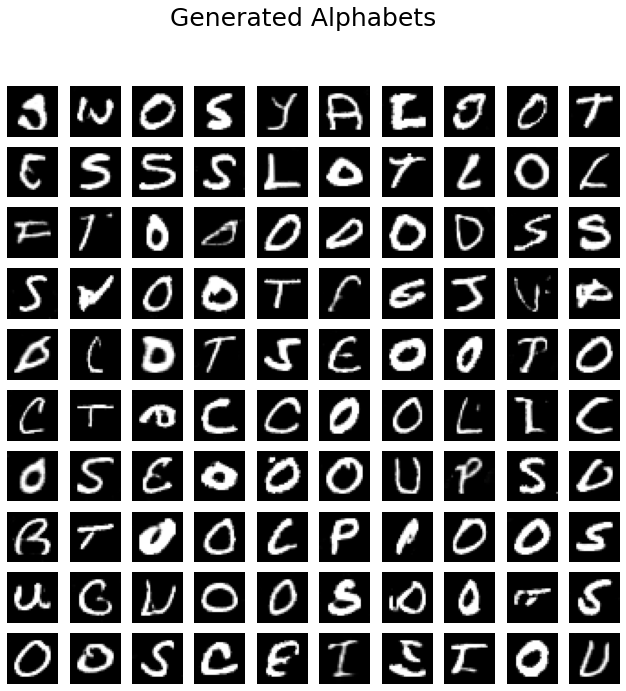

epoch:  71
discriminator loss:  0.4283587336540222
generator loss:  1.9412027597427368
--------------------------------------------------------------------------------
epoch:  72
discriminator loss:  0.4309617280960083
generator loss:  1.8253183364868164
--------------------------------------------------------------------------------
epoch:  73
discriminator loss:  0.4228576421737671
generator loss:  1.7672975063323975
--------------------------------------------------------------------------------
epoch:  74
discriminator loss:  0.43563729524612427
generator loss:  1.5386073589324951
--------------------------------------------------------------------------------
epoch:  75
discriminator loss:  0.4736732840538025
generator loss:  1.595757007598877
--------------------------------------------------------------------------------


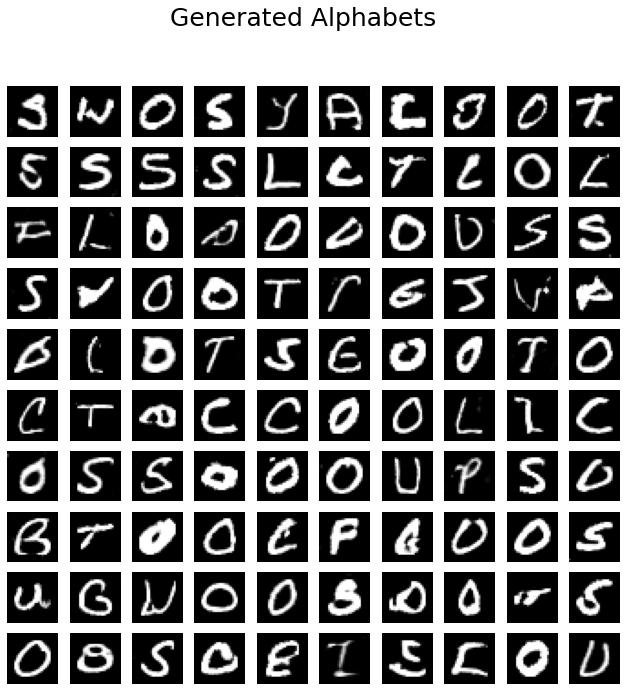

epoch:  76
discriminator loss:  0.44564056396484375
generator loss:  1.9269633293151855
--------------------------------------------------------------------------------
epoch:  77
discriminator loss:  0.4339444637298584
generator loss:  1.6520731449127197
--------------------------------------------------------------------------------
epoch:  78
discriminator loss:  0.4122387766838074
generator loss:  2.202754497528076
--------------------------------------------------------------------------------
epoch:  79
discriminator loss:  0.4268788695335388
generator loss:  1.909364104270935
--------------------------------------------------------------------------------
epoch:  80
discriminator loss:  0.44461268186569214
generator loss:  2.1736621856689453
--------------------------------------------------------------------------------


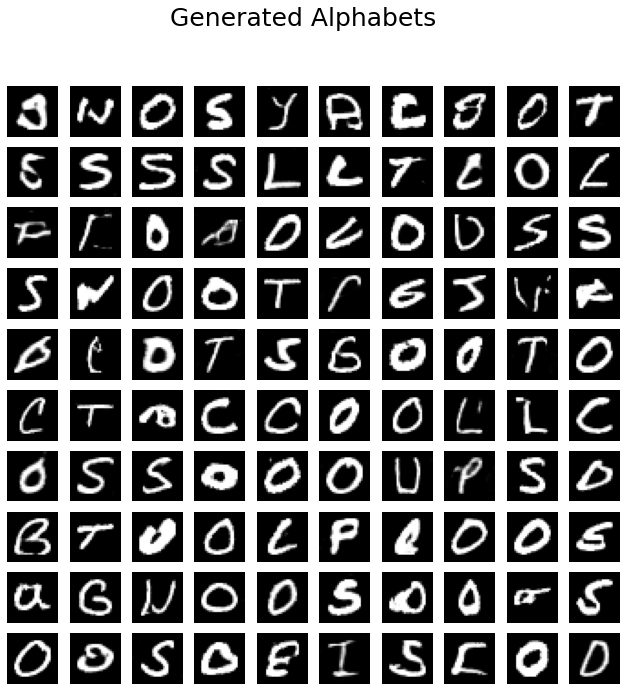

In [17]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)